In [1]:
!pip install gradio

  Obtaining dependency information for gradio from https://files.pythonhosted.org/packages/d8/3c/fcfa9f2f9b97e9c38ccb30eb3edef8acbb284487bc7d8f5b98daf01cf757/gradio-4.12.0-py3-none-any.whl.metadata
  Obtaining dependency information for aiofiles<24.0,>=22.0 from https://files.pythonhosted.org/packages/c5/19/5af6804c4cc0fed83f47bff6e413a98a36618e7d40185cd36e69737f3b0e/aiofiles-23.2.1-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for gradio-client==0.8.0 from https://files.pythonhosted.org/packages/c4/e7/5da3a4b6108f5e2e43d034d7923c3562f93beba8f3d13a0ec7c201a6f33c/gradio_client-0.8.0-py3-none-any.whl.metadata
  Obtaining dependency information for httpx from https://files.pythonhosted.org/packages/39/9b/4937d841aee9c2c8102d9a4eeb800c7dad25386caabb4a1bf5010df81a57/httpx-0.26.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic>=2.0 from https://files.pythonhosted.org/packages/dd/b7/9aea7ee6c01fe3f3c03b8ca3c

In [2]:
import os
import gradio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from PIL import Image, ImageChops

In [3]:
torch.cuda.is_available()

True

In [4]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super().__init__()

        # Encoder
        self.input_to_hidden = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_to_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.hidden_to_log_var = torch.nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.latent_to_hidden = torch.nn.Linear(latent_dim, hidden_dim)
        self.hidden_to_output = torch.nn.Linear(hidden_dim, input_dim)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def Encoder(self, x):
        h = self.input_to_hidden(x)
        mu = self.hidden_to_mu(h)
        log_var = self.hidden_to_log_var(h)
        return mu, log_var

    def Decoder(self, z):
        h = self.latent_to_hidden(z)
        x_hat = torch.sigmoid(self.hidden_to_output(h))
        return x_hat

    def forward(self, X):
        mu, log_var = self.Encoder(X)
        z = self.reparameterize(mu, log_var)
        x_hat = self.Decoder(z)
        return x_hat, mu, log_var

    def loss_function(self, X, x_hat, mu, log_var):
        BCE = torch.nn.functional.mse_loss(x_hat, X, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))
        return BCE + KLD

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5 * logVar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def accuracy(self, X, x_hat):
        X = torchvision.transforms.functional.to_pil_image(X)
        x_hat = torchvision.transforms.functional.to_pil_image(x_hat)
        diff = ImageChops.difference(X, x_hat)
        rms = diff.rms  # Calculate RMS value
        return rms

    def Train(self, X, epochs=100):
        history = []
        x_hat = None
        self.train()
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            x_hat, mean, log_var = self.forward(X)
            loss = self.loss_function(X, x_hat, mean, log_var)
            loss.backward()
            self.optimizer.step()
            print(f'Epoch: {epoch}, Loss: {loss.item()}')
            history.append(loss.item())

        plt.plot(history)
        return history, x_hat

In [5]:
# mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
# train_loader = torch.utils.data.DataLoader(mnist, shuffle=True, batch_size=mnist.train_data.shape[0])
# image, label = next(iter(train_loader))

In [6]:
# Transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Resize((800, 800)),
#     torchvision.transforms.ToPILImage(mode='RGB')
# ])

In [7]:
# dataFromLocal = torchvision.datasets.ImageFolder(root='./data/toys_dataset/images', transform=Transform)
# dataLoader = torch.utils.data.DataLoader(dataFromLocal, shuffle=True, batch_size=300)

In [8]:
# dataLoader.dataset[-1][0]

In [9]:
pathToLocalToPanda = '../toys_dataset/images/Panda/'
pathToLocalToRabbit = '../toys_dataset/images/Rabbit/'

pathToKaggleToPanda = '/kaggle/input/toys-images/images/Panda/'
pathToKaggleToRabbit = '/kaggle/input/toys-images/images/Rabbit/'

pathToPanda = pathToLocalToPanda if os.path.exists(pathToLocalToPanda) else pathToKaggleToPanda
pathToRabbit = pathToLocalToRabbit if os.path.exists(pathToLocalToRabbit) else pathToKaggleToRabbit

In [10]:
images_panda = np.zeros((105, 3 * 100 * 100))
images_rabbit = np.zeros((150, 3 * 100 * 100))

for i, img in enumerate(os.listdir(pathToPanda)):
    im = Image.open(pathToPanda + img)
    im = im.resize((100, 100))
    images_panda[i] = np.array(im).reshape(3 * 100 * 100)
for i, img in enumerate(os.listdir(pathToRabbit)):
    im = Image.open(pathToRabbit + img)
    im = im.resize((100, 100))
    images_rabbit[i] = np.array(im).reshape(3 * 100 * 100)

In [11]:
images_panda = images_panda / 255.
images_rabbit = images_rabbit / 255.

In [12]:
images_panda.shape, images_rabbit.shape

((105, 30000), (150, 30000))

In [13]:
images = np.concatenate((images_panda, images_rabbit))

In [14]:
images = torch.from_numpy(images)

In [15]:
images = images.to(torch.float32)

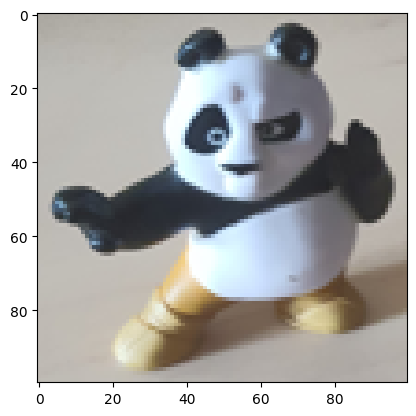

In [16]:
plt.imshow(images[0].reshape(100, 100, 3))

In [17]:
model = VAE(input_dim=30000, latent_dim=20, hidden_dim=300)

In [18]:
model

VAE(
  (input_to_hidden): Linear(in_features=30000, out_features=300, bias=True)
  (hidden_to_mu): Linear(in_features=300, out_features=20, bias=True)
  (hidden_to_log_var): Linear(in_features=300, out_features=20, bias=True)
  (latent_to_hidden): Linear(in_features=20, out_features=300, bias=True)
  (hidden_to_output): Linear(in_features=300, out_features=30000, bias=True)
)

Epoch: 0, Loss: 491627.125
Epoch: 1, Loss: 2399262.5
Epoch: 2, Loss: 1363077.625
Epoch: 3, Loss: 2011134.875
Epoch: 4, Loss: 1710644.625
Epoch: 5, Loss: 895562.875
Epoch: 6, Loss: 1254678.625
Epoch: 7, Loss: 1526969.25
Epoch: 8, Loss: 1447843.5
Epoch: 9, Loss: 1007565.625
Epoch: 10, Loss: 6999259.5
Epoch: 11, Loss: 1377430.125
Epoch: 12, Loss: 1789706.75
Epoch: 13, Loss: 2287348.0
Epoch: 14, Loss: 1435324.0
Epoch: 15, Loss: 1203477.75
Epoch: 16, Loss: 946888.25
Epoch: 17, Loss: 803350.0625
Epoch: 18, Loss: 660509.625
Epoch: 19, Loss: 687084.25
Epoch: 20, Loss: 761070.875
Epoch: 21, Loss: 937075.0625
Epoch: 22, Loss: 848192.4375
Epoch: 23, Loss: 711092.875
Epoch: 24, Loss: 631181.1875
Epoch: 25, Loss: 601181.125
Epoch: 26, Loss: 683953.1875
Epoch: 27, Loss: 780199.375
Epoch: 28, Loss: 831051.5
Epoch: 29, Loss: 707694.5
Epoch: 30, Loss: 707543.75
Epoch: 31, Loss: 652521.5625
Epoch: 32, Loss: 615714.125
Epoch: 33, Loss: 715721.875
Epoch: 34, Loss: 639801.3125
Epoch: 35, Loss: 697844.25
Ep

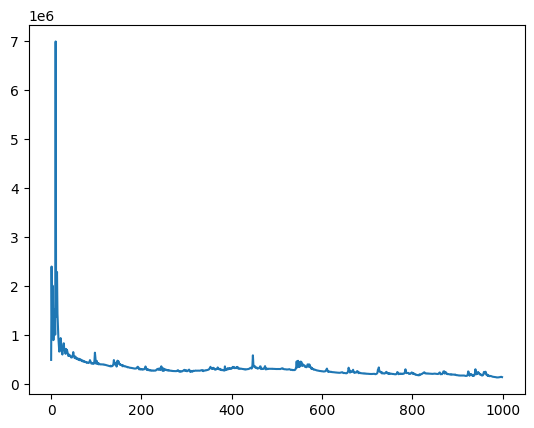

In [19]:
_, x_reconstructed = model.Train(images, epochs=1000)

In [20]:
x_reconstructed.shape

torch.Size([255, 30000])

In [21]:
x_reconstructed[0].shape

torch.Size([30000])

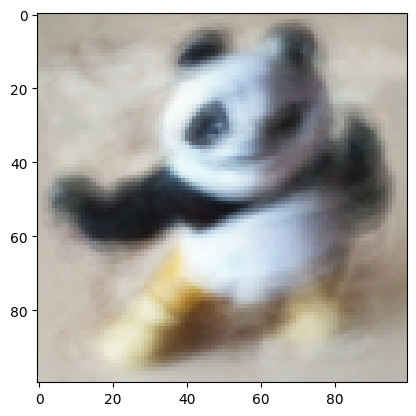

In [22]:
plt.imshow(x_reconstructed[0].detach().numpy().reshape(100, 100, 3))

In [23]:
def plotting(num_images=10):
    plt.figure(figsize=(20, 20))
    f = plt.gcf()
    for i in range(num_images):
        # display original
        ax = plt.subplot(10, 2, 2 * i + 1)
        plt.imshow(images[i].reshape(100, 100, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(10, 2, 2 * i + 2)
        plt.imshow(x_reconstructed[i].detach().numpy().reshape(100, 100, 3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig = plt.gcf()
    fig.savefig('Reconstructed.jpeg')
    created_image = Image.open('Reconstructed.jpeg')
    plt.show()
    return created_image

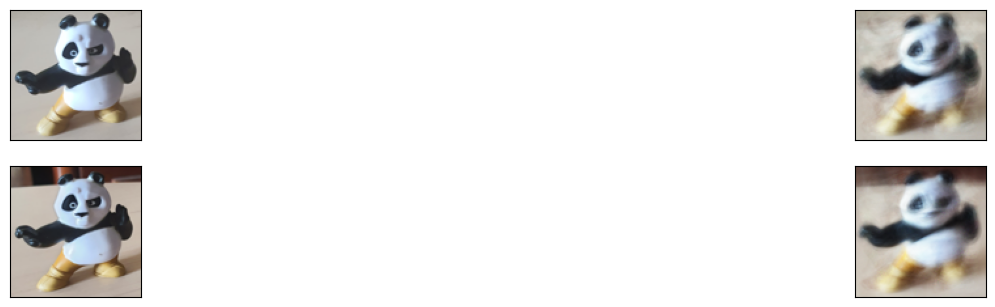

In [24]:
created_image = plotting(2)

In [25]:
interface = gradio.Interface(plotting, gradio.Slider(1, 10, label="Choose number images", step=1), gradio.Image(label="Reconstructed Images", show_label=True))

In [26]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://60bc8086e9e9758106.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
